# Outliers fjernelse og plot af ét signal

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pod5 as p5

def load_data(tsv_file, pod_file):
    # Load data from tsv-file
    polyA_df = pd.read_csv(tsv_file, sep='\t', skiprows=1, skipfooter=3, engine='python')
    polyA_df.columns = polyA_df.columns.str.strip()  # Fix possible whitespace in headers

    # Load data from pod5-file
    with p5.Reader(pod_file) as reader:
        pod_data = {str(read.read_id): read.signal for read in reader.reads()}

    # Adds pod5 data to dataframe by read_ids
    polyA_df['signal'] = polyA_df['read_id'].map(pod_data)  # Adds NaN if read_id not found in pod data
    
    # Removes NaNs from dataframe if there is any
    polyA_df.dropna(subset=['signal'], inplace=True)

    return polyA_df

In [2]:
# Loads data from tsv and pod5 file
df = load_data("egfp_a120_1mod_polyA_position.tsv", "egfp_a120_1mod_polya_reads.pod5")

In [3]:
def remove_outliers(signal, threshold, tail_start, index=None, return_mask=False):
    # Computes the length of the signal before outliers are removed
    original_length = len(signal)

    mean = np.mean(signal)
    std = np.std(signal)
    
    if std == 0:
        # If std is 0 nothing is an outlier and the signal will be returned
        # If return_mask = True, the signal and a boolean array of outlier status is returned
        return signal if not return_mask else (signal, np.full(len(signal), True))

    z_scores = np.abs((signal - mean) / std)
    mask = z_scores < threshold  # returns True if value if z-score is below the threshold
    filtered_signal = signal[mask]  # returns signal where mask is True (signal without outliers)

    # Calculates how many values are removed
    removed_count = np.sum(~mask)  # takes the sum of True values in the inverted mask array
    
    # Computes the length of the signal after outliers are removed
    filtered_length = len(filtered_signal)

    # Adjust indexes to match original indexes
    removed_indices = np.where(~mask)[0] + tail_start

    if index is not None:
        print(f"Row {index}: Length before = {original_length}, length after = {filtered_length}, removed count = {removed_count} ({(removed_count/original_length)*100:.2f}%)")
        if removed_count > 0:
            print(f"Removed indexes: {removed_indices}")

    # Returns filtered signal if return_mask = False
    # Returns filtered signal and a boolean array of outlier status for original data if return_mask = True
    return filtered_signal if not return_mask else (filtered_signal, mask)

def vectorize_and_plot(row, vector_length, window_size_avg, window_size_var, threshold, index=None):
    read_id = row['read_id']
    raw_signal = row['signal']
    start = row['start']
    end = row['end']

    # Only takes signal of PolyA-tail
    signal = raw_signal[start:end]

    # Plots raw signal of PolyA-tail
    plt.figure(figsize=(12, 4))
    plt.plot(range(start, end), signal, color='blue', alpha=0.7)
    plt.title(f"Raw signal - Read {read_id}")
    plt.xlabel("Sample Index")
    plt.ylabel("Current (pA)")
    plt.grid(True)
    plt.show()

    # Uses function above to remove outlies from PolyA-tail signal
    signal = remove_outliers(signal, threshold, tail_start=start, index=index)

    # Computes 25-75% quantile region
    first_quantile = int(0.25 * len(signal))
    third_quantile = int(0.75 * len(signal))

    # Defines the signal in the 50% region
    signal50 = signal[first_quantile:third_quantile]
    
    # Checks that signal50 is not empty
    if len(signal50) == 0:
        return

    # Computes the mean of signal50
    signal50_mean = np.mean(signal50)

    # Checks that mean is not 0 before dividing
    if signal50_mean == 0:
        return

    # Divides signal by the mean of signal50
    normalized = signal / signal50_mean

    # Empty lists for the means and variances
    means = []
    variances = []
 
    # Loop over lenght of the vector 
    for j in range(vector_length):
        # Calculates evenly spaced position 'x' along the signal
        x = int(j * (len(signal) / vector_length))

        # Defines the start and end index of the window around position x
        start_index_avg = max(int(x - (window_size_avg // 2)), 0)
        end_index_avg = min(int(x + (window_size_avg // 2)), len(normalized))
        
        # Defines the window around x
        window_avg = normalized[start_index_avg:end_index_avg]

        # Appends the correct mean value of the window to the list 'means'
        means.append(np.mean(window_avg) if len(window_avg) > 0 else np.nan)

        # Repeats for the var values
        start_index_var = max(int(x - (window_size_var // 2)), 0)
        end_index_var = min(int(x + (window_size_var // 2)), len(normalized))
        
        window_var = normalized[start_index_var:end_index_var]
        
        # Appends the correct variance value of the window to the list 'variances'
        variances.append(np.var(window_var) if len(window_var) > 0 else np.nan)

    # Creates an array of evenly spaced integers starting from 0 up to vector_length - 1
    x_vals = np.arange(vector_length)

    # Plot Mean
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, means, label='Mean', color='blue')
    plt.title(f"Mean - Read {read_id}")
    plt.xlabel("Window Index")
    plt.ylabel("Normalized Mean")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot variance
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, variances, label='Variance', color='orange')
    plt.title(f"Variance - Read {read_id}")
    plt.xlabel("Window Index")
    plt.ylabel("Variance")
    plt.legend()
    plt.grid(True)
    plt.show()

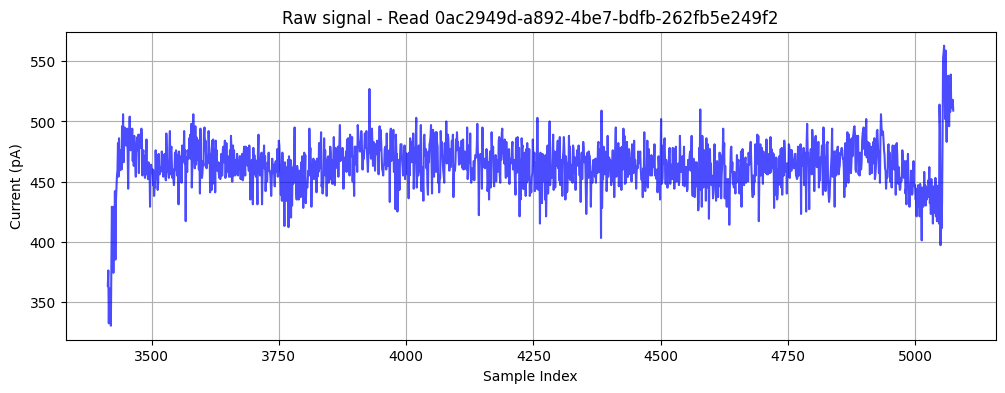

Row 22: Length before = 1662, length after = 1638, removed count = 24 (1.44%)
Removed indexes: [3414 3415 3416 3417 3418 3419 3420 3421 3425 3427 3429 3928 4383 5013
 5050 5055 5056 5057 5058 5060 5064 5065 5068 5070]


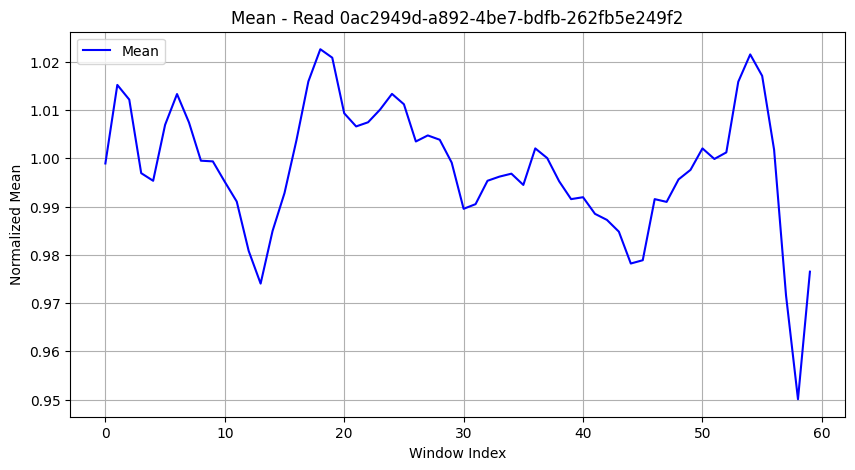

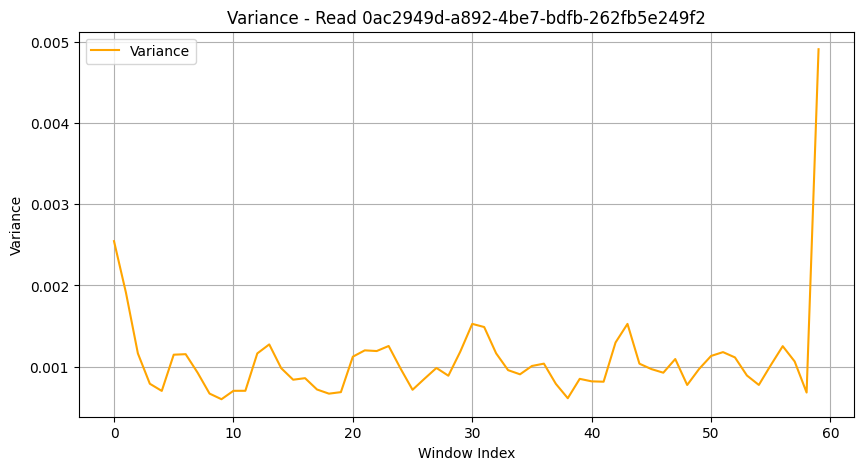

In [4]:
row = 22
vectorize_and_plot(df.iloc[row], vector_length=60, window_size_avg=60, window_size_var=60, threshold=3,index=row)